In [1]:
# First let's simulate STDP with Brian2 library
!pip install brian2

  Obtaining dependency information for brian2 from https://files.pythonhosted.org/packages/a1/bb/06490ebf430acf48cfdd1a88b9bff6aaba3e50f1982364996fff68ec2668/Brian2-2.5.4-cp311-cp311-macosx_10_9_universal2.whl.metadata
  Obtaining dependency information for cython>=0.29 from https://files.pythonhosted.org/packages/e3/7f/f584f5d15323feb897d42ef0e9d910649e2150d7a30cf7e7a8cc1d236e6f/Cython-3.0.8-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.4 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [2]:
# Simulate 1 second with 1000 connected randomly distributed spiked synapses
from brian2 import *

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 15*Hz
gmax = .01
dApre = .05
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

poisson_input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(poisson_input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
mon2 = StateMonitor(S, 'Apost', record=[0, 1])
mon3 = StateMonitor(S, 'Apre', record=[0, 1])
m = StateMonitor(neurons, 'v', record=0)
spike_monitor = SpikeMonitor(poisson_input)
s_mon = SpikeMonitor(poisson_input)

run(1*second, report='text')

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in < 1s


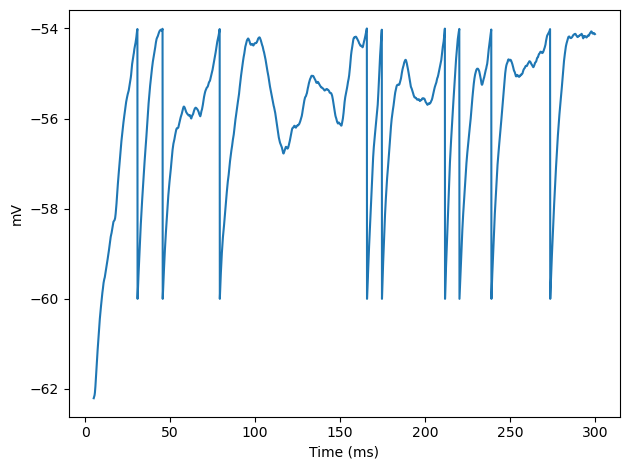

In [3]:
# Plot the brian2 spikes of the neuron
plot(m.t[50:3000]/ms, m.v[0][50:3000]/ms)
xlabel('Time (ms)')
ylabel('mV')
tight_layout()
show()

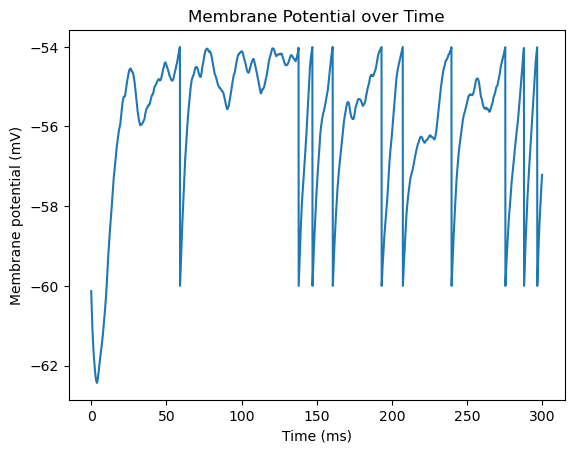

In [30]:
# Now implement STDP manually and plot the spikes
import numpy as np
import matplotlib.pyplot as plt
import random

# Time parameters
T = 300.0      # total time to simulate (ms)
dt = 0.1     # simulation time step (ms)
time = np.arange(0, T, dt)
vr = -60


# Neuron parameters
El = -74      # Resting membrane potential (mV)
Ee = 0        # Excitatory reversal potential (mV)
taue = 5      # Excitatory synaptic time constant (ms)
taum = 10     # Membrane time constant (ms)

# Initial conditions
initialV = vr        # Membrane potential initialized to resting potential
initialGe = 0.0      # Initial synaptic conductance

Vth = -54     # Spike threshold (mV)
taupre = 20
taupost = taupre
gmax = .01

dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

# Define 1 neuron

neuron = { 'V': initialV, 'ge': initialGe, 'V_trace': [] }

# Define simulated neuron stimulations for this inputs
simulatedInputNr = 1000
rate_hz = 15
total_time_seconds = 1

lambda_per_millisecond = rate_hz / total_time_seconds / 1000
lambda_per_timestep = lambda_per_millisecond * dt
activations_2d = np.random.poisson(lambda_per_timestep, (simulatedInputNr, len(time)))
binary_activations_2d = np.where(activations_2d > 0, 1, 0)

synapse = { 'input': binary_activations_2d,
           'to_neuron': neuron,
            'Apre': np.zeros(simulatedInputNr),
            'Apost': np.zeros(simulatedInputNr),
            'w': np.random.rand(simulatedInputNr) * gmax
          }
neuronSpiked = False
w_trace = np.zeros((N, len(time)))  # Initialize a 2D array to store weights over time

# Simulation
for i, t in enumerate(time):
  # STDP synapse part
  # get current inputs
  currentInputs = synapse['input'][:, i]

  # if there is no spike
  if np.all(currentInputs == 0) and not neuronSpiked:
    synapse['Apre'] -= (synapse['Apre'] / taupre) * dt
    synapse['Apost'] -= (synapse['Apost'] / taupost) * dt


  # check for post synaptic spikes - wich means that the single neuron fired
  if neuronSpiked:
    neuronSpiked = False
    synapse['Apost'] = synapse['Apost'] + dApost
    synapse['w'] = np.clip(synapse['w'] + synapse['Apre'], 0, gmax)
  else:
    # Update each synapse based on pre-synaptic spikes
    for j in range(simulatedInputNr):
        if currentInputs[j] == 1:  # If there is a pre-synaptic spike
            synapse['Apre'][j] += dApre
            synapse['w'][j] = np.clip(synapse['w'][j] + synapse['Apost'][j], 0, gmax)
            neuron['ge'] += synapse['w'][j]
  w_trace[:, i] = synapse['w']
  # neuron part
  dVdt = (neuron['ge'] * (Ee - neuron['V']) + (El - neuron['V'])) / taum
  neuron['V'] += dt * dVdt
  neuron['ge'] += dt * (-neuron['ge']) / taue

  # Check for spikes
  if neuron['V'] >= Vth:
    neuron['V'] = vr
    neuronSpiked = True

  neuron['V_trace'].append(neuron['V'])

plt.plot(time, neuron['V_trace'])
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Membrane Potential over Time')
plt.show()

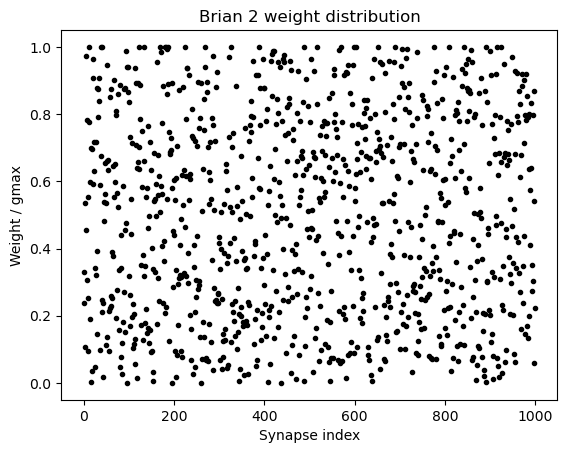

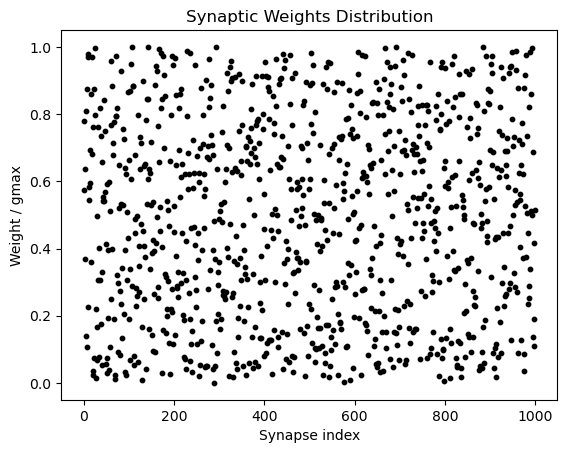

In [21]:
# Plot the brian weights distribution and then weights distribution from manually imeplemented STDP

# Brian 2
figure()
title('Brian 2 weight distribution')
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
show()

# Manual STDP
figure()
plt.scatter(range(simulatedInputNr), synapse['w'] / gmax, s=10, c='k')
plt.xlabel('Synapse index')
plt.ylabel('Weight / gmax')
plt.title('Synaptic Weights Distribution')
show()

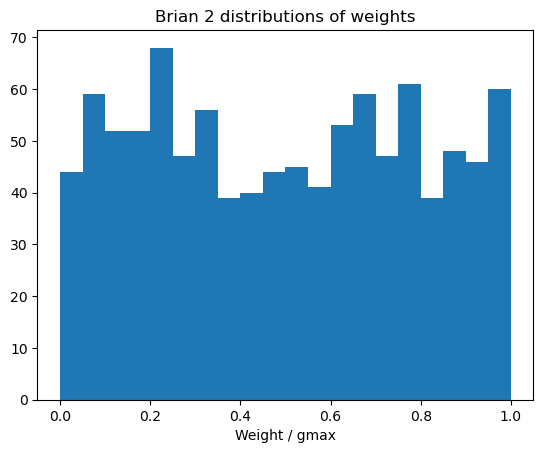

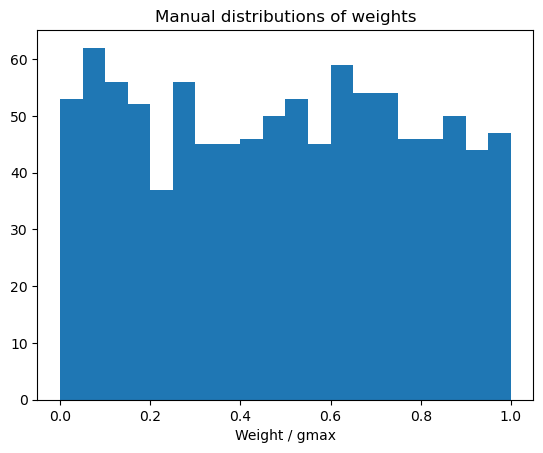

In [24]:
# Plot histogram of weights

# First brian2
figure()
hist(S.w / gmax, 20)
title('Brian 2 distributions of weights')
xlabel('Weight / gmax')
show()

# Now manual
figure()
hist(synapse['w'] / gmax, 20)
title('Manual distributions of weights')
xlabel('Weight / gmax')
show()

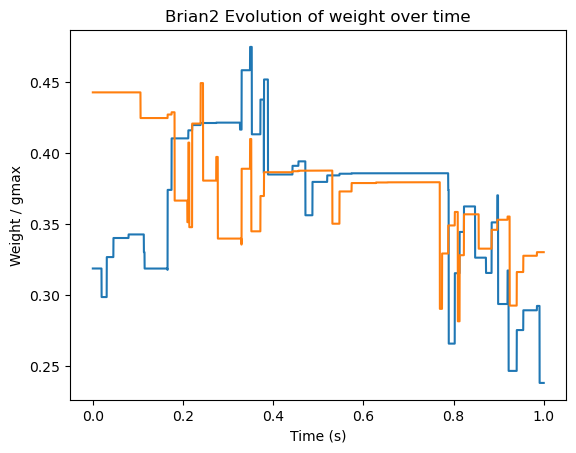

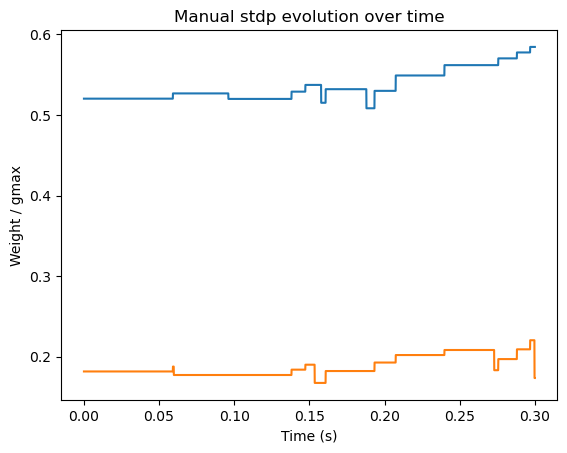

In [32]:
figure()
title('Brian2 Evolution of weight over time')
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
show()

figure()
title('Manual stdp evolution over time')
plot(time/1000, w_trace[0, :]/gmax)
plot(time/1000, w_trace[1, :]/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
show()